In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
path = "/media/dan/Data/manuscripts/manuiscript_0001_hfo_rates/data/FULL_composite_patient_info.csv"
df = pd.read_csv(path)
pat = df[df['pid'] == 1]
xyz = pat[['x', 'y', 'z']].values

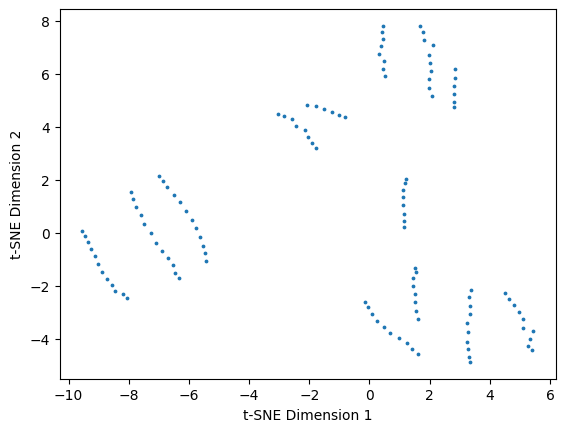

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
data_tsne = tsne.fit_transform(X=xyz)

# Plot the results
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], s=3)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [36]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from tqdm import tqdm
# from scipy.optimize import curve_fit


# path = "/media/dan/Data/git/network_miner/temp/data/064_000500_0000.5.hdf5"
path = "/media/dan/Data/git/network_miner/temp/data/064_000500_000050.hdf5"
# path = "/media/dan/Data/git/eeg_prep/processed_files/064_000500_000500.hdf5"
# path = "F:\\git\\network_miner\\temp\\data\\064_000500_00500.hdf5"
# path = "/media/dan/Data/git/eeg_prep/processed_files/014_000500_000500.hdf5"
stop = 2048*3
with h5py.File(path, "r") as f:
    print(f['data']['A_mats'].shape)
    # A_mats = f['data']['A_mats'][:,:,:stop]
    # A_mats_mask = f['data']['A_mask'][:stop]
    A_mats = f['data']['A_mats'][:,:,:]
    A_mats_mask = f['data']['A_mask'][:]
    soz = f['metadata']["patient_info"]['soz'][:].astype(bool)
    chnames = f['metadata']['channels'][:]
    # bytestring to string
    chnames = [name.decode('utf-8') for name in chnames]
    chnames = np.array(chnames)

n_max = 3

A_org = A_mats[:,:,A_mats_mask==1]
eye = np.eye(A_org.shape[0]) == 1
A_abs = np.abs(A_org)
A_abs[eye,:] = np.nan
A_zeros = np.zeros_like(A_org)
A_norm = np.zeros_like(A_org)
# normalize 0-1 for each row so each row at each time point is 0-1 
for time in tqdm(range(A_abs.shape[-1])):
    # Get the 2D matrix at the specific time step
    slice_t = A_abs[:, :, time]
    
    # Normalize each row individually
    row_min = np.nanmin(slice_t, axis=1, keepdims=True)
    row_max = np.nanmax(slice_t, axis=1, keepdims=True)
    
    # Avoid division by zero in case of zero-variance rows
    # normalized_slice = (slice_t - row_min) / (row_max - row_min + 1e-10)
    normalized_slice = (slice_t - row_min) / (row_max - row_min)
    # set nan to 0
    normalized_slice[np.isnan(normalized_slice)] = 0
    max_idxs = np.argsort(normalized_slice, axis=-1)[:,-n_max:]

    zeros = np.zeros_like(normalized_slice)
    for x in range(zeros.shape[0]):
        zeros[x,max_idxs[x]] = 1
    # # Place the normalized slice back into A
    A_zeros[:, :, time] = zeros
    A_norm[:, :, time] = normalized_slice
    
# set nan to 0
A_abs[np.isnan(A_abs)] = 0
A_zeros[np.isnan(A_zeros)] = 0
A_norm[np.isnan(A_norm)] = 0


(192, 192, 6040)


100%|██████████| 6021/6021 [00:05<00:00, 1143.90it/s]


In [38]:
A_mats.shape

(192, 192, 6040)

<Axes: >

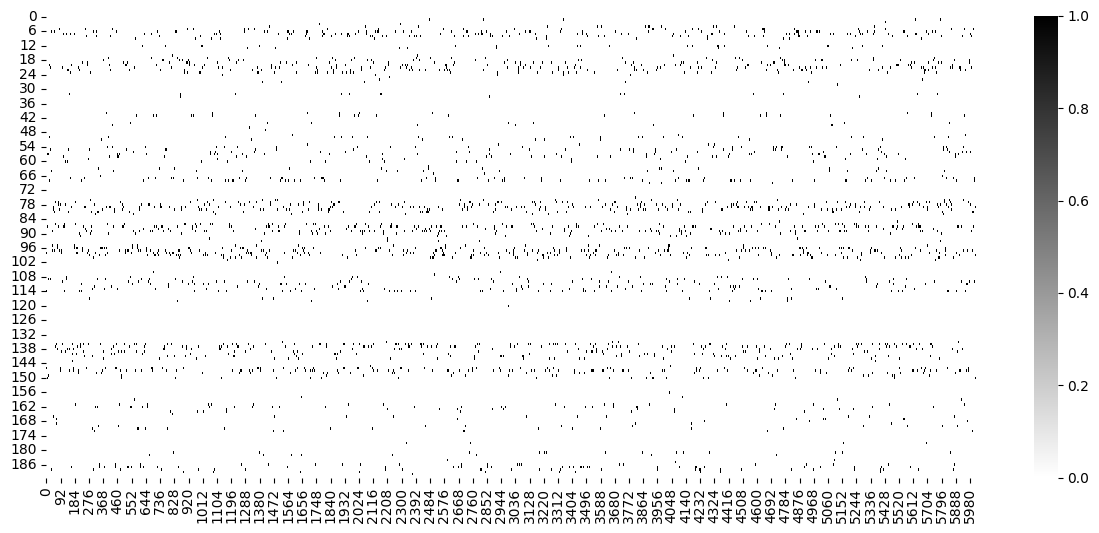

In [37]:
plt.figure(figsize=(15, 6))
sns.heatmap(A_zeros[0,:,:], cmap='binary')